In [1]:
import os
import sys
import supervision as sv
import subprocess
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image

In [2]:

HOME = os.getcwd()
print(HOME)
%cd {HOME}
#!git clone https://github.com/IDEA-Research/GroundingDINO.git
#%cd {HOME}/GroundingDINO
#!pip install -q -e .
#!pip install -q roboflow

/home/yaxun/FoundationPose/GroundingDINO
/home/yaxun/FoundationPose/GroundingDINO


In [3]:


WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join("weights", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

weights/groundingdino_swint_ogc.pth ; exist: True


In [5]:


CONFIG_PATH = os.path.join("groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True


In [6]:
%cd {HOME}
# %conda install -c pytorch pytorch torchvision
# import os, sys
# current_path = os.getcwd()
# if current_path not in sys.path:
#     sys.path.append(current_path)

from groundingdino.util.inference import load_model, load_image, predict, annotate

model = load_model(CONFIG_PATH, WEIGHTS_PATH)

[Errno 2] No such file or directory: '{HOME}'
/home/yaxun/FoundationPose/GroundingDINO


final text_encoder_type: bert-base-uncased


data/73.jpg


SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


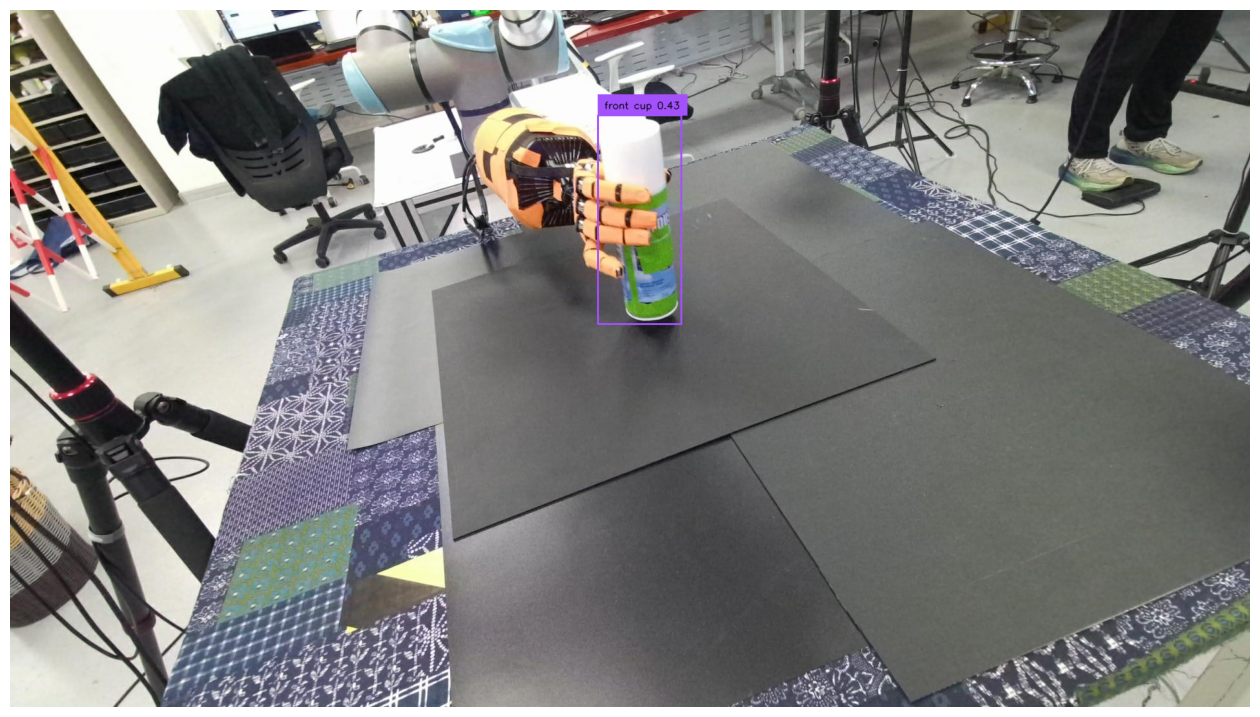

In [9]:

IMAGE_NAME = "73.jpg"
IMAGE_PATH = os.path.join("data", IMAGE_NAME)

TEXT_PROMPT = "front cup"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

print(IMAGE_PATH)
image_source, image = load_image(IMAGE_PATH)
boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))

In [13]:
print(boxes)

tensor([[0.5078, 0.3016, 0.0674, 0.2994]])


In [23]:
def generate_points_in_box(boxe):
    x_c = boxe[0]
    y_c = boxe[1]
    w = boxe[2]
    h = boxe[3]
    x_min =int(x_c - 0.5 * w) 
    y_min = int(y_c - 0.5 * h)
    x_max = int(x_c + 0.5 * w)
    y_max = int(y_c + 0.5 * h)
    points = [(x, y) for x in range(x_min, x_max + 1) for y in range(y_min, y_max + 1)]
    return points

def boxes2masks(boxes,width, height):
    #width, height = img.size
    boxes = boxes * torch.Tensor([width, height, width, height])
    boxes_cpu = boxes.detach().cpu()
    boxes_np = boxes_cpu.numpy()
    print(boxes_np)
    masks = []    
    for boxe in boxes_np :
        temp_mask = np.zeros((height, width), dtype=np.uint8)
        for point in generate_points_in_box(boxe) :
            temp_mask[point[1]][point[0]]=255

        masks.append(temp_mask)
    return masks

In [17]:
H, W, _ = image_source.shape

In [24]:
masks=boxes2masks(boxes,W, H)

[[975.05914 325.72095 129.33205 323.3093 ]]


In [ ]:
%cd {HOME}


# 克隆 GitHub 仓库
subprocess.run(["git", "clone", "https://github.com/facebookresearch/segment-anything.git"])
%cd {HOME}/segment-anything

In [ ]:
%cd {HOME}
import subprocess

subprocess.run(["mkdir", "{HOME}/samweights"])
%cd {HOME}/samweights
subprocess.run(["wget", "-q", "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"])

In [ ]:
%cd {HOME}/segment-anything
from segment_anything import build_sam, SamPredictor

In [ ]:


DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

sam_checkpoint = f'/{HOME}/sam_vit_h_4b8939.pth'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)

In [ ]:
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=-1)

In [ ]:

image = cv2.imread(f'/{HOME}/data/dog-2.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
# set image
sam_predictor.set_image(image)
# box: normalized box xywh -> unnormalized xyxy
H, W, _ = image_source.shape
boxes_xyxy = box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])
print(boxes_xyxy)

In [ ]:
transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(DEVICE)
masks, _, _ = sam_predictor.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes = transformed_boxes,
            multimask_output = False,
        )

In [ ]:
def show_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.cpu().reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

In [ ]:

annotated_frame = annotated_frame[...,::-1] # BGR to RGB
annotated_frame_with_mask = show_mask(masks[0][0], annotated_frame)
Image.fromarray(annotated_frame_with_mask)

In [25]:
image_mask = masks[0][0].cpu().numpy()
image_source_pil = Image.fromarray(image_source)
annotated_frame_pil = Image.fromarray(annotated_frame)
image_mask_pil = Image.fromarray(image_mask)
#annotated_frame_with_mask_pil = Image.fromarray(annotated_frame_with_mask)
image_mask_pil

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [ ]:
rgb = image.convert("RGB")
image_np = np.array(rgb)
num_proposals = len(masks)
rgb = self.rgb_normalize(image_np).to(masks.device).float()
rgbs = rgb.unsqueeze(0).repeat(num_proposals, 1, 1, 1)
masked_rgbs = rgbs * masks.unsqueeze(1)

In [ ]:
masked_rgbs

In [ ]:
class CropResizePad:
    def __init__(self, target_size):
        if isinstance(target_size, int):
            target_size = (target_size, target_size)
        self.target_size = target_size
        self.target_ratio = self.target_size[1] / self.target_size[0]
        self.target_h, self.target_w = target_size
        self.target_max = max(self.target_h, self.target_w)

    def __call__(self, images, boxes):
        box_sizes = boxes[:, 2:] - boxes[:, :2]
        scale_factor = self.target_max / torch.max(box_sizes, dim=-1)[0]
        processed_images = []
        for image, box, scale in zip(images, boxes, scale_factor):
            # crop and scale
            image = image[:, box[1] : box[3], box[0] : box[2]]
            image = F.interpolate(image.unsqueeze(0), scale_factor=scale.item())[0]
            # pad and resize
            original_h, original_w = image.shape[1:]
            original_ratio = original_w / original_h

            # check if the original and final aspect ratios are the same within a margin
            if self.target_ratio != original_ratio:
                padding_top = max((self.target_h - original_h) // 2, 0)
                padding_bottom = self.target_h - original_h - padding_top
                padding_left = max((self.target_w - original_w) // 2, 0)
                padding_right = self.target_w - original_w - padding_left
                image = F.pad(
                    image, (padding_left, padding_right, padding_top, padding_bottom)
                )
            assert image.shape[1] == image.shape[2], logging.info(
                f"image {image.shape} is not square after padding"
            )
            image = F.interpolate(
                image.unsqueeze(0), scale_factor=self.target_h / image.shape[1]
            )[0]
            processed_images.append(image)
        return torch.stack(processed_images)


In [ ]:
rgb_proposal_processor = CropResizePad(224)

In [ ]:
processed_masked_rgbs = rgb_proposal_processor(masked_rgbs, boxes)

In [ ]:
dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')

In [ ]:
features = dinov2_vitl14(processed_masked_rgbs)

In [ ]:
image=torch.from_numpy(np.array(image_mask_pil) / 255).float()

In [ ]:
bach = bach.expand(-1, 3, -1, -1)

In [ ]:
images = []
images.append(image)
bachimg = []
bachimg.append(images)
bach = torch.tensor(np.array(bachimg))